# Libraries

In [1]:
import xarray as xr
from datetime import datetime

import torch

from aurora import AuroraSmall, Batch, Metadata, rollout
import matplotlib.pyplot as plt

from pathlib import Path

import cdsapi
import numpy as np
from sklearn.metrics import root_mean_squared_error
import gcsfs

from torch.utils.data import Dataset
from aurora import Batch, Metadata
import os

/home/koomi_aims_ac_za/koomi/projects/AIMS-PROJECT/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import sys
sys.path.append(os.path.abspath("../src"))
from utils import get_surface_feature_target_data, get_atmos_feature_target_data
from utils import get_static_feature_target_data, create_batch, predict_fn, rmse_weights
from utils import rmse_fn, plot_rmses

# Load the model

In [9]:
# model = AuroraSmall()

# model.load_state_dict(torch.load('../model/aurora.pth'))

# Data

In [10]:
fs = gcsfs.GCSFileSystem(token="anon")

store = fs.get_mapper('gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr')
full_era5 = xr.open_zarr(store=store, consolidated=True, chunks=None)

### Subset data

#### world

In [18]:
start_time = '2022-01-01'
end_time = '2022-01-02'

sliced_era5_world = (
    full_era5
    .sel(time=slice(start_time, end_time))
)

#### South Africa

In [19]:

lat_max = -22.00 
lat_min = -37.75  

lon_min = 15.25   
lon_max = 35.00   

sliced_era5_sa = (
    full_era5
    .sel(
        time=slice(start_time, end_time),
        latitude=slice(lat_max, lat_min),
        longitude=slice(lon_min, lon_max)  
    )
)

In [20]:
selected_times=sliced_era5_world.time

world_latitudes = sliced_era5_world.latitude
world_longitudes = sliced_era5_world.longitude

sa_latitudes = sliced_era5_sa.latitude
sa_longitudes = sliced_era5_sa.longitude

world_rmse_weights = rmse_weights(world_latitudes, world_longitudes)[1:,:]
sa_rmse_weights = rmse_weights(sa_latitudes, sa_longitudes)

world_rmses_list=[]; pred_dates_list=[]
sa_rmses_list=[]
for i in range(1, len(sliced_era5_world.time)-2):
    # get current and previous time step data
    world_feature_data =  (
            sliced_era5_world
            .sel(time=slice(selected_times[i-1], selected_times[i]))
        )
    sa_feature_data =  (
            sliced_era5_sa
            .sel(time=slice(selected_times[i-1], selected_times[i]))
        )
    # get  the next to timz step data
    world_target_data =  (
            sliced_era5_world
            .sel(time=slice(selected_times[i+1], selected_times[i+2]))
        )
    sa_target_data =  (
            sliced_era5_sa
            .sel(time=slice(selected_times[i+1], selected_times[i+2]))
        )
    
    # get each type of data(surface, static atmosphere)
    world_feature_surface_data, world_target_surface_data = get_surface_feature_target_data(world_feature_data, world_target_data)
    world_feature_atmos_data, world_target_atmos_data = get_atmos_feature_target_data(world_feature_data, world_target_data)
    world_feature_static_data, world_target_static_data = get_static_feature_target_data(world_feature_data, world_target_data)
    
    sa_feature_surface_data, sa_target_surface_data = get_surface_feature_target_data(sa_feature_data, sa_target_data)
    sa_feature_atmos_data, sa_target_atmos_data = get_atmos_feature_target_data(sa_feature_data, sa_target_data)
    sa_feature_static_data, sa_target_static_data = get_static_feature_target_data(sa_feature_data, sa_target_data)
    
    # create batch for each of them
    world_feature_bacth =  create_batch(world_feature_surface_data, world_feature_atmos_data, world_feature_static_data)
    world_target_bacth = create_batch(world_target_surface_data, world_target_atmos_data, world_target_static_data)
    
    sa_feature_bacth =  create_batch(sa_feature_surface_data, sa_feature_atmos_data, sa_feature_static_data)
    sa_target_bacth = create_batch(sa_target_surface_data, sa_target_atmos_data, sa_target_static_data)
    # get prediction
    world_predictions = predict_fn(batch=world_feature_bacth)
    sa_predictions = predict_fn(batch=sa_feature_bacth)
    # compute the rmse
    world_rmses, world_pred_dates = rmse_fn(predictions=world_predictions, 
            target_batch=world_target_bacth, var_name="2t",
            weigths=world_rmse_weights)
    
    sa_rmses, sa_pred_dates = rmse_fn(predictions=sa_predictions, 
            target_batch=sa_target_bacth, var_name="2t",
            weigths=sa_rmse_weights, area="sa")
    # append result to the list
    world_rmses_list.append(world_rmses); pred_dates_list.append(world_pred_dates)
    sa_rmses_list.append(sa_rmses)
    

In [23]:
sa_rmses_list

[[1.2520530223846436, 1.6168991327285767],
 [1.4184519052505493, 1.3129541873931885],
 [1.0893759727478027, 1.0503556728363037],
 [0.8492061495780945, 1.545436978340149],
 [1.3824716806411743, 1.5901851654052734]]

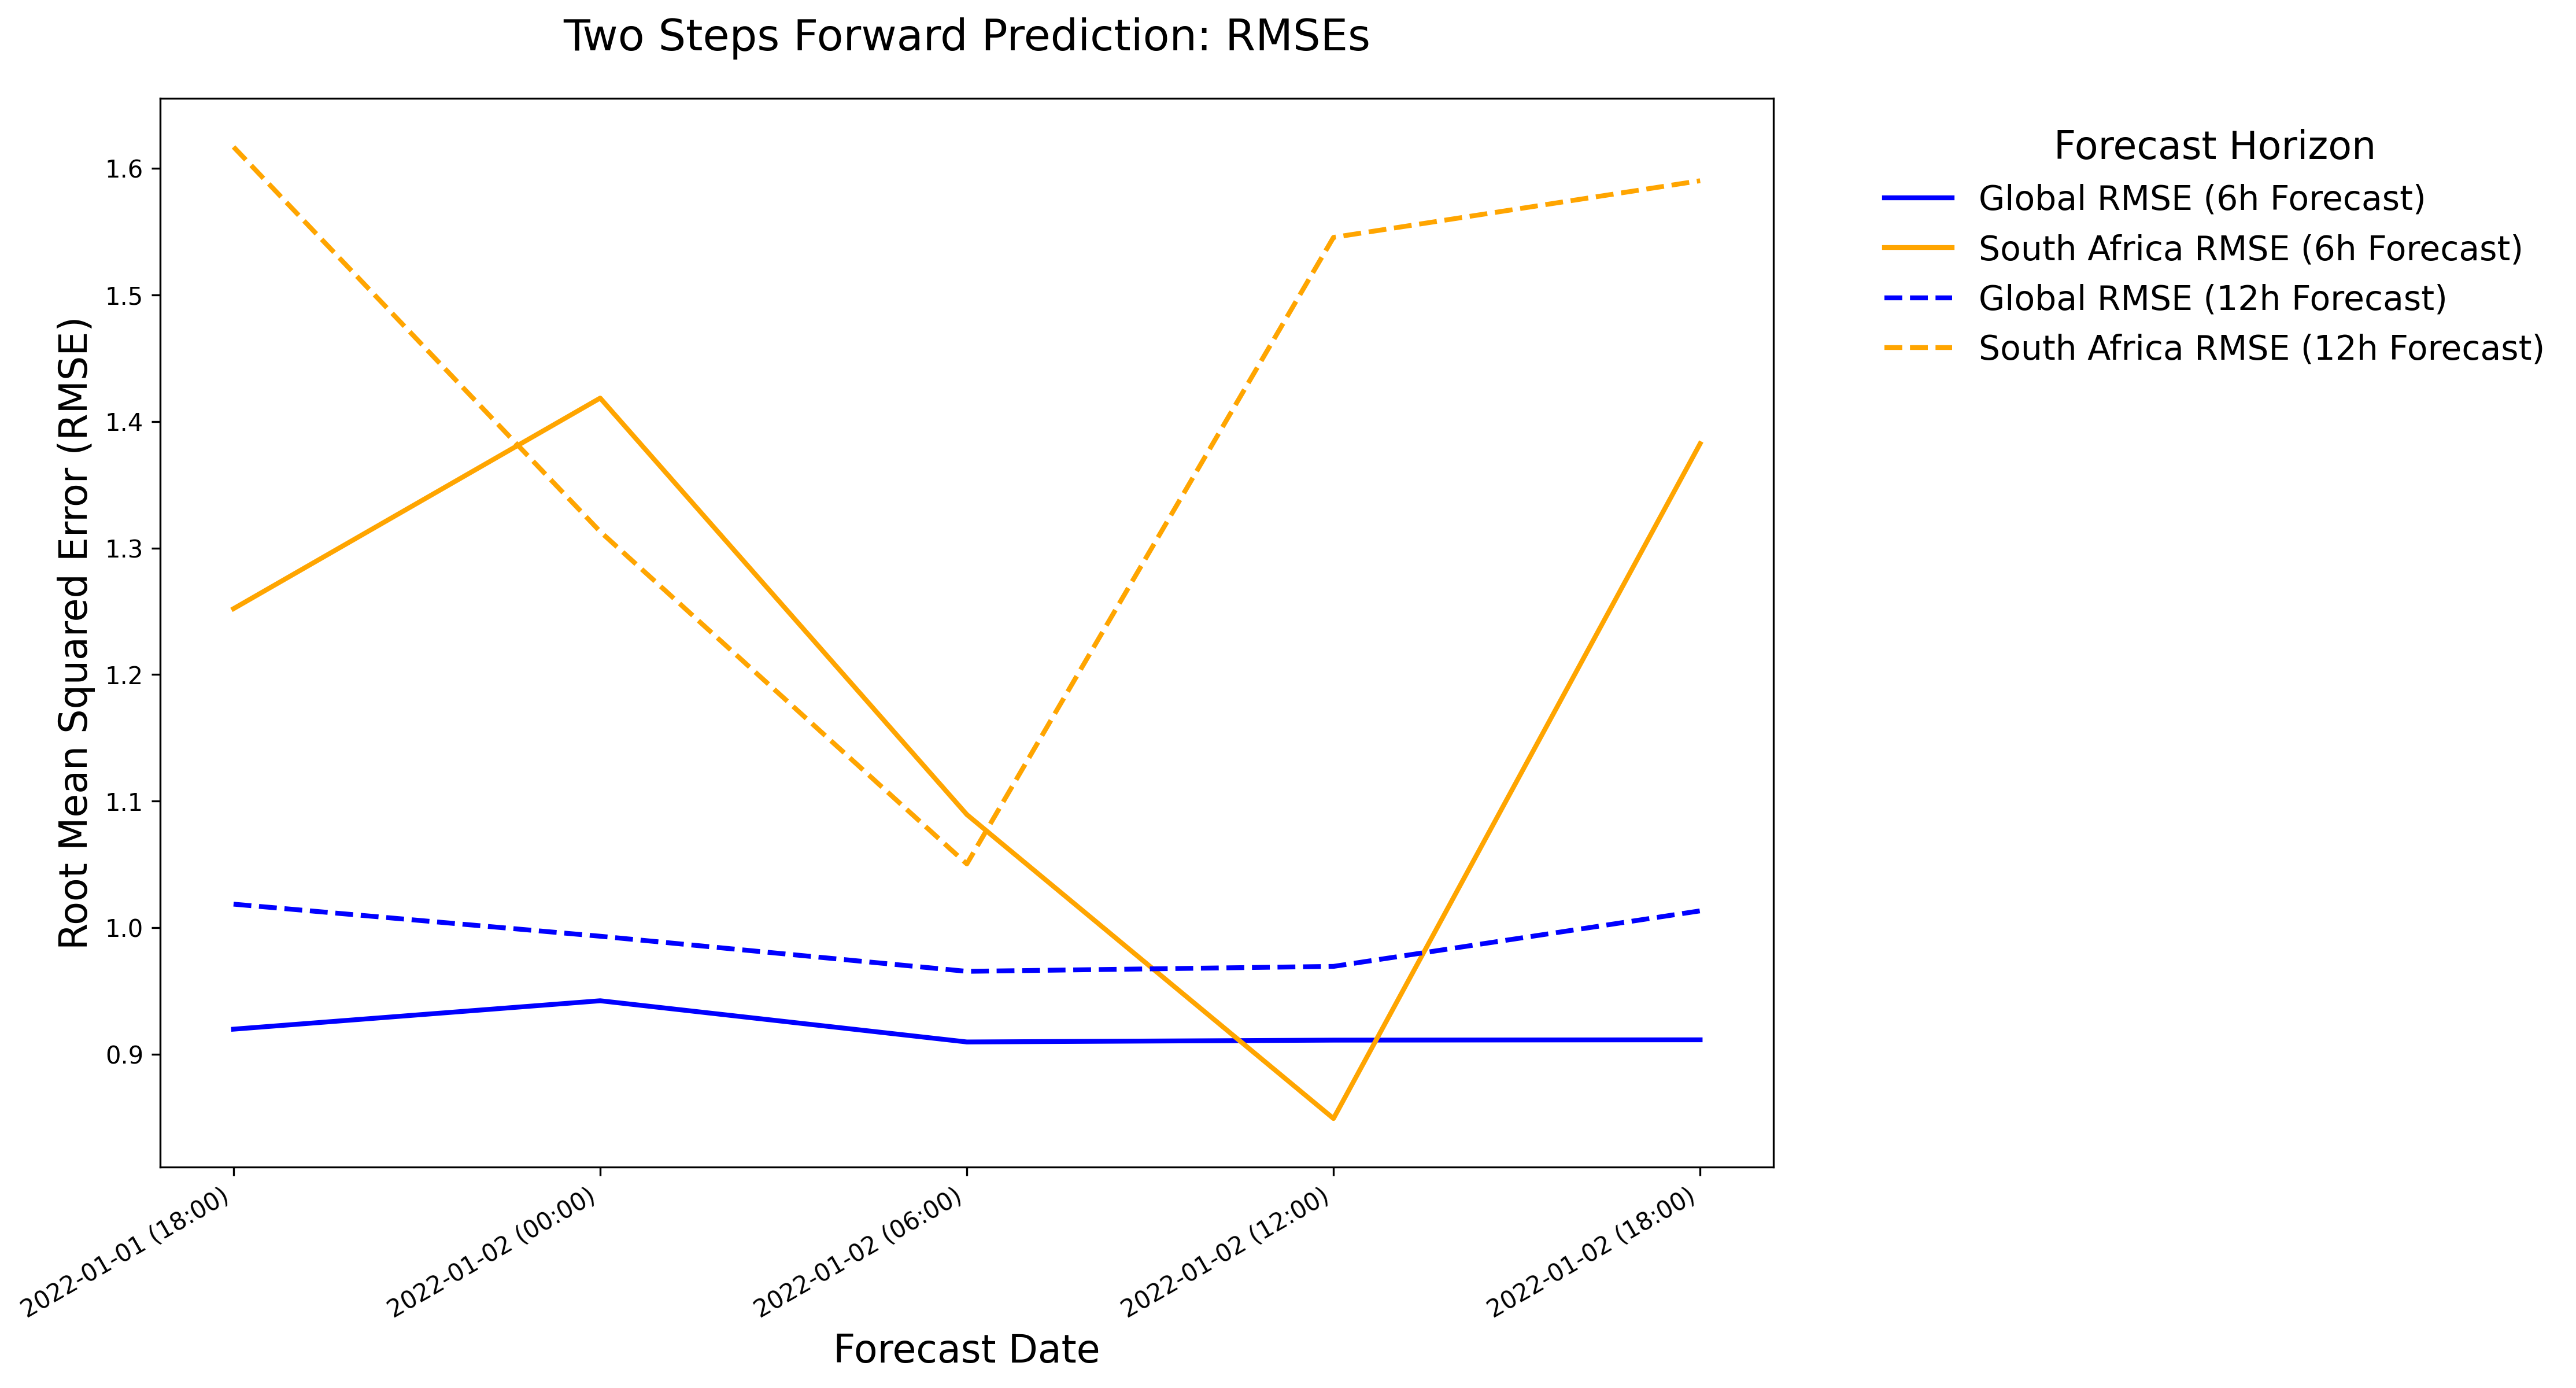

In [24]:
plot_rmses("2t", world_rmses_list, sa_rmses_list, 
               figsize=(12, 8), fontsize=18,
               date_ranges=pred_dates_list, 
               title="Two Steps Forward Prediction: RMSEs",
               save_path="../report/era5",
               atmos_level=None)

In [100]:
for i in range(1,len(sliced_era5_world.time)-2):
    print(i)

1
2
3


In [ ]:
sliced_era5_world.time[1]

In [92]:
sliced_era5_world1 = (
    full_era5
    .sel(time=slice(sliced_era5_world.time[1], sliced_era5_world.time[3]))
)

In [93]:
surf_vars_ds1 = sliced_era5_world1[surface_vars]

In [97]:
surf_vars_ds1["2m_temperature"].values[[1 - 1, 1]].shape

(2, 721, 1440)

In [87]:
sliced_era5_world1 .time

<xarray.DataArray 'time' (time: 2)> Size: 16B
array(['2022-06-01T06:00:00.000000000', '2022-06-01T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16B 2022-06-01T06:00:00 2022-06-01T12:00:00

In [83]:
data_inner_steps = 2  # Number of consecutive time steps in each chunk

# Get total number of time steps
num_time_steps = sliced_era5_world.sizes["time"]

# Iterate over time indices in steps of `data_inner_steps`
for i in range(0, num_time_steps - (2 * data_inner_steps) + 1, data_inner_steps):
    # Select feature time steps
    sliced_era5_features = sliced_era5_world.isel(time=slice(i, i + data_inner_steps))
    
    # Select target time steps (next consecutive steps)
    sliced_era5_targets = sliced_era5_world.isel(time=slice(i + data_inner_steps, i + 2 * data_inner_steps))
    
    # Now, `sliced_era5_features` contains (t₁, t₂) and `sliced_era5_targets` contains (t₃, t₄)
    # Next iteration: features (t₃, t₄), targets (t₅, t₆)
    
    print(f"Feature time range: {sliced_era5_features.time.values}")
    print(f"Target time range: {sliced_era5_targets.time.values}")


Feature time range: ['2022-06-01T00:00:00.000000000' '2022-06-01T06:00:00.000000000']
Target time range: ['2022-06-01T12:00:00.000000000' '2022-06-01T18:00:00.000000000']
Feature time range: ['2022-06-01T12:00:00.000000000' '2022-06-01T18:00:00.000000000']
Target time range: ['2022-06-02T00:00:00.000000000' '2022-06-02T06:00:00.000000000']


In [9]:
target_sliced_era5_world = (
    full_era5
    .sel(time=slice(start_time, end_time))  # Select the time range
    .isel(time=slice(2, None))  # Skip the first two time steps
)

### Surface variables

In [10]:
# List of surface variable names
surface_vars = ['2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', 'mean_sea_level_pressure']

# Select surface variables
surf_vars_ds = sliced_era5_world[surface_vars]
target_surf_vars_ds = target_sliced_era5_world[surface_vars]


### Atmospherique variables

In [11]:
atmostpheric_variables = ["temperature", "u_component_of_wind", "v_component_of_wind", "specific_humidity", "geopotential"]
atmos_vars_ds = sliced_era5_world[atmostpheric_variables]
target_atmos_vars_ds = target_sliced_era5_world[atmostpheric_variables]

## Static variables

In [12]:
static_variables = ["land_sea_mask", "soil_type", "geopotential_at_surface"]
static_vars_ds = sliced_era5_world[static_variables]
target_static_vars_ds = target_sliced_era5_world[static_variables]

## Create batches

In [13]:

class ERA5ZarrDataset(Dataset):
    def __init__(self, surf_vars_ds, atmos_vars_ds, static_vars_ds, sequence_length):
        self.surf_vars_ds = surf_vars_ds
        self.atmos_vars_ds = atmos_vars_ds
        self.static_vars_ds = static_vars_ds
        self.sequence_length = sequence_length
        self.time_indices = range(sequence_length, len(surf_vars_ds.time))

    def __len__(self):
        return len(self.time_indices)

    def __getitem__(self, idx):
        i = self.time_indices[idx]

        surf_vars = {
            "2t": torch.from_numpy(self.surf_vars_ds["2m_temperature"].values[[i - 1, i]][None]),
            "10u": torch.from_numpy(self.surf_vars_ds["10m_u_component_of_wind"].values[[i - 1, i]][None]),
            "10v": torch.from_numpy(self.surf_vars_ds["10m_v_component_of_wind"].values[[i - 1, i]][None]),
            "msl": torch.from_numpy(self.surf_vars_ds["mean_sea_level_pressure"].values[[i - 1, i]][None]),
        }

        static_vars = {
            "z": torch.from_numpy(self.static_vars_ds["geopotential_at_surface"].values),
            "slt": torch.from_numpy(self.static_vars_ds["soil_type"].values),
            "lsm": torch.from_numpy(self.static_vars_ds["land_sea_mask"].values),
        }

        atmos_vars = {
            "t": torch.from_numpy(self.atmos_vars_ds["temperature"].values[[i - 1, i]][None]),
            "u": torch.from_numpy(self.atmos_vars_ds["u_component_of_wind"].values[[i - 1, i]][None]),
            "v": torch.from_numpy(self.atmos_vars_ds["v_component_of_wind"].values[[i - 1, i]][None]),
            "q": torch.from_numpy(self.atmos_vars_ds["specific_humidity"].values[[i - 1, i]][None]),
            "z": torch.from_numpy(self.atmos_vars_ds["geopotential"].values[[i - 1, i]][None]),
        }

        metadata=Metadata(
        lat=torch.from_numpy(self.surf_vars_ds.latitude.values),
        lon=torch.from_numpy(self.surf_vars_ds.longitude.values),
        time=(self.surf_vars_ds.time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in self.atmos_vars_ds.level.values)
    )


        return Batch(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, metadata=metadata)


In [14]:
world_batches = ERA5ZarrDataset(surf_vars_ds, atmos_vars_ds, static_vars_ds,1)
target_world_batches = ERA5ZarrDataset(target_surf_vars_ds, target_atmos_vars_ds, target_static_vars_ds,1)

### South Africa Data

In [15]:

lat_max = -22.00 
lat_min = -37.75  

lon_min = 15.25   
lon_max = 35.00   

sliced_era5_SA = (
    full_era5
    .sel(
        time=slice(start_time, end_time),
        latitude=slice(lat_max, lat_min),
        longitude=slice(lon_min, lon_max)  
    )
    .isel(time=slice(None, -2))
)

target_sliced_era5_SA = (
    full_era5
    .sel(
        time=slice(start_time, end_time),
        latitude=slice(lat_max, lat_min),
        longitude=slice(lon_min, lon_max)  
    )  
    .isel(time=slice(2, None))  # Skip the first two time steps
)

In [16]:
surf_vars_ds_SA = sliced_era5_SA[surface_vars]

target_surf_vars_ds_SA = target_sliced_era5_SA[surface_vars]

atmos_vars_ds_SA = sliced_era5_SA[atmostpheric_variables]

target_atmos_vars_ds_SA = target_sliced_era5_SA[atmostpheric_variables]

static_vars_ds_SA = sliced_era5_SA[static_variables]

target_static_vars_ds_SA = target_sliced_era5_SA[static_variables]

In [17]:
SA_batches = ERA5ZarrDataset(surf_vars_ds_SA, atmos_vars_ds_SA, static_vars_ds_SA,1)
target_SA_batches = ERA5ZarrDataset(target_surf_vars_ds_SA, target_atmos_vars_ds_SA, target_static_vars_ds_SA,1)

## Predictions Function

In [36]:
def predict_fn(model, batch):
    model.eval()
    model = model.to("cuda")
    # batch = batch.to("cuda")
    with torch.inference_mode():
        preds = [pred for pred in rollout(model, batch, steps=2)]
    return preds

# Custom RMSE function

## Grid weights

In [37]:

def rmse_weights(latitudes, longitudes, R=6371.0, device="cuda"):
    """
    Compute area weights for RMSE calculation over a global grid.

    Parameters:
        latitudes (array-like): 1D array of latitudes (degrees).
        longitudes (array-like): 1D array of longitudes (degrees).
        R (float): Earth's radius in km (default: 6371.0).
        device (str): 'cpu' or 'cuda' for GPU acceleration.

    Returns:
        torch.Tensor: Area weights normalized to sum to 1.
    """
    # Convert lat/lon to radians
    lat_rad = np.deg2rad(latitudes)
    lon_rad = np.deg2rad(longitudes)

    # Compute latitude and longitude differences
    dlat = np.abs(np.diff(lat_rad).mean())  # Average latitude difference
    dlon = np.abs(np.diff(lon_rad).mean())  # Average longitude difference

    # Calculate area weights
    areas = R**2 * dlon * np.abs(np.sin(lat_rad + dlat / 2) - np.sin(lat_rad - dlat / 2))

    # Expand areas to create a 2D area weight grid
    area_grid = np.outer(areas, np.ones(len(longitudes)))

    # Normalize the area weights
    area_grid /= area_grid.sum()

    # Convert to PyTorch tensor
    return torch.tensor(area_grid, dtype=torch.float32, device=device)


### world rmse weights

In [38]:
world_rmse_weights = rmse_weights(sliced_era5_world.latitude, sliced_era5_world.longitude, R=6371.0)

### South Africa rmse weights

In [39]:
SA_rmse_weights = rmse_weights(sliced_era5_SA.latitude, sliced_era5_SA.longitude, R=6371.0)

In [40]:
def custom_rmse(actual, prediction, weights):
    """
    Compute the weighted RMSE (Root Mean Square Error).

    Parameters:
        actual (torch.Tensor): Ground truth values.
        prediction (torch.Tensor): Predicted values.
        weights (torch.Tensor): Area weights (normalized).

    Returns:
        torch.Tensor: Weighted RMSE.
    """
    device = actual.device  # Get the device of `actual`
    prediction = prediction.to(device)
    weights = weights.to(device)


    # Compute weighted squared error
    squared_error = ((actual - prediction) ** 2) * weights

    # Compute and return the sum of the squared errors (RMSE without sqrt)
    return torch.sqrt(squared_error.sum() / weights.sum())


# RMSEs World dataset

In [51]:
def rmse_fn(model, feature_batch, target_batch, var_name, weigths=world_rmse_weights, var_type="surface", atmos_level_idx=0):
    predictions = predict_fn(model, batch=feature_batch)
    two_steps_rmse = []
    pred_dates = []
    for i in range(len(predictions)):
        pred = predictions[i]
        if var_type=="surface":
            prediction = pred.surf_vars[var_name][0, 0]#.numpy()
            actual = target_batch.surf_vars[var_name].squeeze()[i,:,:][1:, :]
            # actual = target_batch.surf_vars[var_name][0, 0].numpy()
            
            # rmse = root_mean_squared_error(actual.flatten(), prediction.flatten())
            rmse_ = custom_rmse(actual, prediction, weigths[1:,:])
            # print(rmse1)
            two_steps_rmse.append(rmse_.item())
            pred_dates.append(pred.metadata.time[0])
        # Atmospherique variable
        elif var_type=="atmosphere":
            prediction = pred.atmos_vars[var_name].squeeze()[atmos_level_idx,:,:].numpy().squeeze()
            # actual = target_batch.atmos_vars[var_name].squeeze()[i,:,:][1:, :]
            actual = target_batch.atmos_vars[var_name].squeeze()[i,atmos_level_idx,:,:].numpy()[:-1,:]
            # rmse = root_mean_squared_error(actual.flatten(), prediction.flatten())
            rmse_ = custom_rmse(actual, prediction, weigths[1:,:])
            two_steps_rmse.append(rmse_.item())
            pred_dates.append(pred.metadata.time[0])
    return two_steps_rmse, pred_dates

# RMSEs South Africa dataset

In [77]:
def rmse_fn_sa(model, actual_batch, target_batch, var_name, weigths=SA_rmse_weights, var_type="surface",  atmos_level_idx=0):
    predictions = predict_fn(model, batch=actual_batch)
    two_steps_rmse = []
    pred_dates = []
    for i in range(len(predictions)):
        pred = predictions[i]
        if var_type=="surface":
            # prediction = pred.surf_vars[var_name][0, 0].numpy()
            # actual = actual_batch.surf_vars[var_name][0, 0].numpy()
            # rmse = root_mean_squared_error(actual.flatten(), prediction.flatten())
            prediction = pred.surf_vars[var_name][0, 0]#.numpy()
            actual = target_batch.surf_vars[var_name].squeeze()[i,:,:]
            # rmse1 = rmse(actual, prediction)
            computed_rmse = custom_rmse(actual, prediction, weigths)
            two_steps_rmse.append(computed_rmse.item())
            pred_dates.append(pred.metadata.time[0])
            # print(computed_rmse.item())
        elif var_type=="atmosphere":
            prediction = pred.atmos_vars[var_name].squeeze()[atmos_level_idx,:,:].numpy().squeeze()
            actual = target_batch.atmos_vars[var_name].squeeze()[i,atmos_level_idx,:,:].numpy()
            # rmse = root_mean_squared_error(actual.flatten(), prediction.flatten())
            rmse_ = custom_rmse(actual, prediction, weigths)
            two_steps_rmse.append(rmse_.item())
            pred_dates.append(pred.metadata.time[0])
    return two_steps_rmse, pred_dates

# PLot RMSES

In [53]:

def plot_rmses(variable, rmses_world, rmses_sa, 
               figsize=(12, 8), fontsize=18,
               date_ranges=None, 
               title="Two Steps Forward Prediction: RMSEs",
               save_path="../report/rmses_world_SA",
               atmos_level=None):

    fig, ax = plt.subplots(figsize=figsize, dpi=300)

    # Extract dates
    date_times_6_hours = [date1 for date1, date2 in date_ranges]
    date_times_12_hours = [date2 for date1, date2 in date_ranges]
    formatted_dates_6_hours = [dt.strftime('%Y-%m-%d (%H:%M)') for dt in date_times_6_hours]
    formatted_dates_12_hours = [dt.strftime('%Y-%m-%d (%H:%M)') for dt in date_times_12_hours]

    # Convert x-axis to indices
    x_indices = np.arange(len(formatted_dates_6_hours))

    # Select a subset of dates for x-axis labels
    num_ticks = min(6, len(formatted_dates_6_hours))
    tick_positions = np.linspace(0, len(formatted_dates_6_hours) - 1, num_ticks, dtype=int)

    # Plot RMSEs with improved colors and styles
    ax.plot(x_indices, np.array(rmses_world)[:, 0], label="Global RMSE (6h Forecast)", color="blue", linestyle="-", linewidth=2)
    ax.plot(x_indices, np.array(rmses_sa)[:, 0], label="South Africa RMSE (6h Forecast)", color="orange", linestyle="-", linewidth=2)
    ax.plot(x_indices, np.array(rmses_world)[:, 1], label="Global RMSE (12h Forecast)", color="blue", linestyle="--", linewidth=2)
    ax.plot(x_indices, np.array(rmses_sa)[:, 1], label="South Africa RMSE (12h Forecast)", color="orange", linestyle="--", linewidth=2)

    # Set selected x-ticks
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([formatted_dates_12_hours[i] for i in tick_positions], rotation=30, ha='right')

    # Improve legend appearance
    ax.legend(title="Forecast Horizon", title_fontsize=fontsize-2, fontsize=fontsize-4,
              bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)

    # Improve axis labels and title
    ax.set_xlabel("Forecast Date", fontsize=fontsize-2)
    ax.set_ylabel("Root Mean Squared Error (RMSE)", fontsize=fontsize-2)
    ax.set_title(title, fontsize=fontsize, pad=20)
    if atmos_level:
        # Save the plots
        plt.savefig(f"{save_path}/rmse-{variable}-{atmos_level}.pdf", bbox_inches="tight")
        plt.savefig(f"{save_path}/rmse-{variable}-{atmos_level}.png", bbox_inches="tight")
        plt.savefig(f"{save_path}/rmse-{variable}-{atmos_level}.svg", bbox_inches="tight")
    else:
        plt.savefig(f"{save_path}/rmse-{variable}.pdf", bbox_inches="tight")
        plt.savefig(f"{save_path}/rmse-{variable}.png", bbox_inches="tight", dpi=300)
        plt.savefig(f"{save_path}/rmse-{variable}.svg", bbox_inches="tight")

    plt.show()


# Surface Variables

## Two-meter temperature in K: 2t

In [54]:
from torch.utils.data import DataLoader
import gc

In [55]:
rmses_world_2t = []
dates_world_2t = []

for batch, target_batch in zip(world_batches, target_world_batches):
    batch = batch.to("cuda")
    target_batch = target_batch.to("cuda")
    rmse, date = rmse_fn(model, feature_batch=batch, target_batch=target_batch, var_name="2t", var_type="surface")
    print("Done")
    rmses_world_2t.append(rmse)
    dates_world_2t.append(date)
    del batch, target_batch, rmse, date
    torch.cuda.empty_cache()  # Free GPU memory

Done
Done
Done
Done
Done


In [68]:
rmses_world_2t

[[0.8860846161842346, 0.9621628522872925],
 [0.9221225380897522, 0.9249922633171082],
 [0.8659918308258057, 0.933040201663971],
 [0.9182277321815491, 0.9579838514328003],
 [0.9057708382606506, 0.9753555059432983]]

In [78]:
rmses_SA_2t = []
dates_SA_2t = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse_, date = rmse_fn_sa(model, actual_batch=batch, target_batch=target_batch, var_name="2t", var_type="surface")
    rmses_SA_2t.append(rmse_)
    dates_SA_2t.append(date)
    del batch, target_batch, rmse_, date
    torch.cuda.empty_cache()  # Free GPU memory

In [79]:
rmses_SA_2t

[[2.7906250953674316, 1.9343945980072021],
 [1.6670539379119873, 2.099936008453369],
 [1.5879337787628174, 4.967696189880371],
 [3.6749167442321777, 1.3063453435897827],
 [2.044055223464966, 2.227492570877075]]

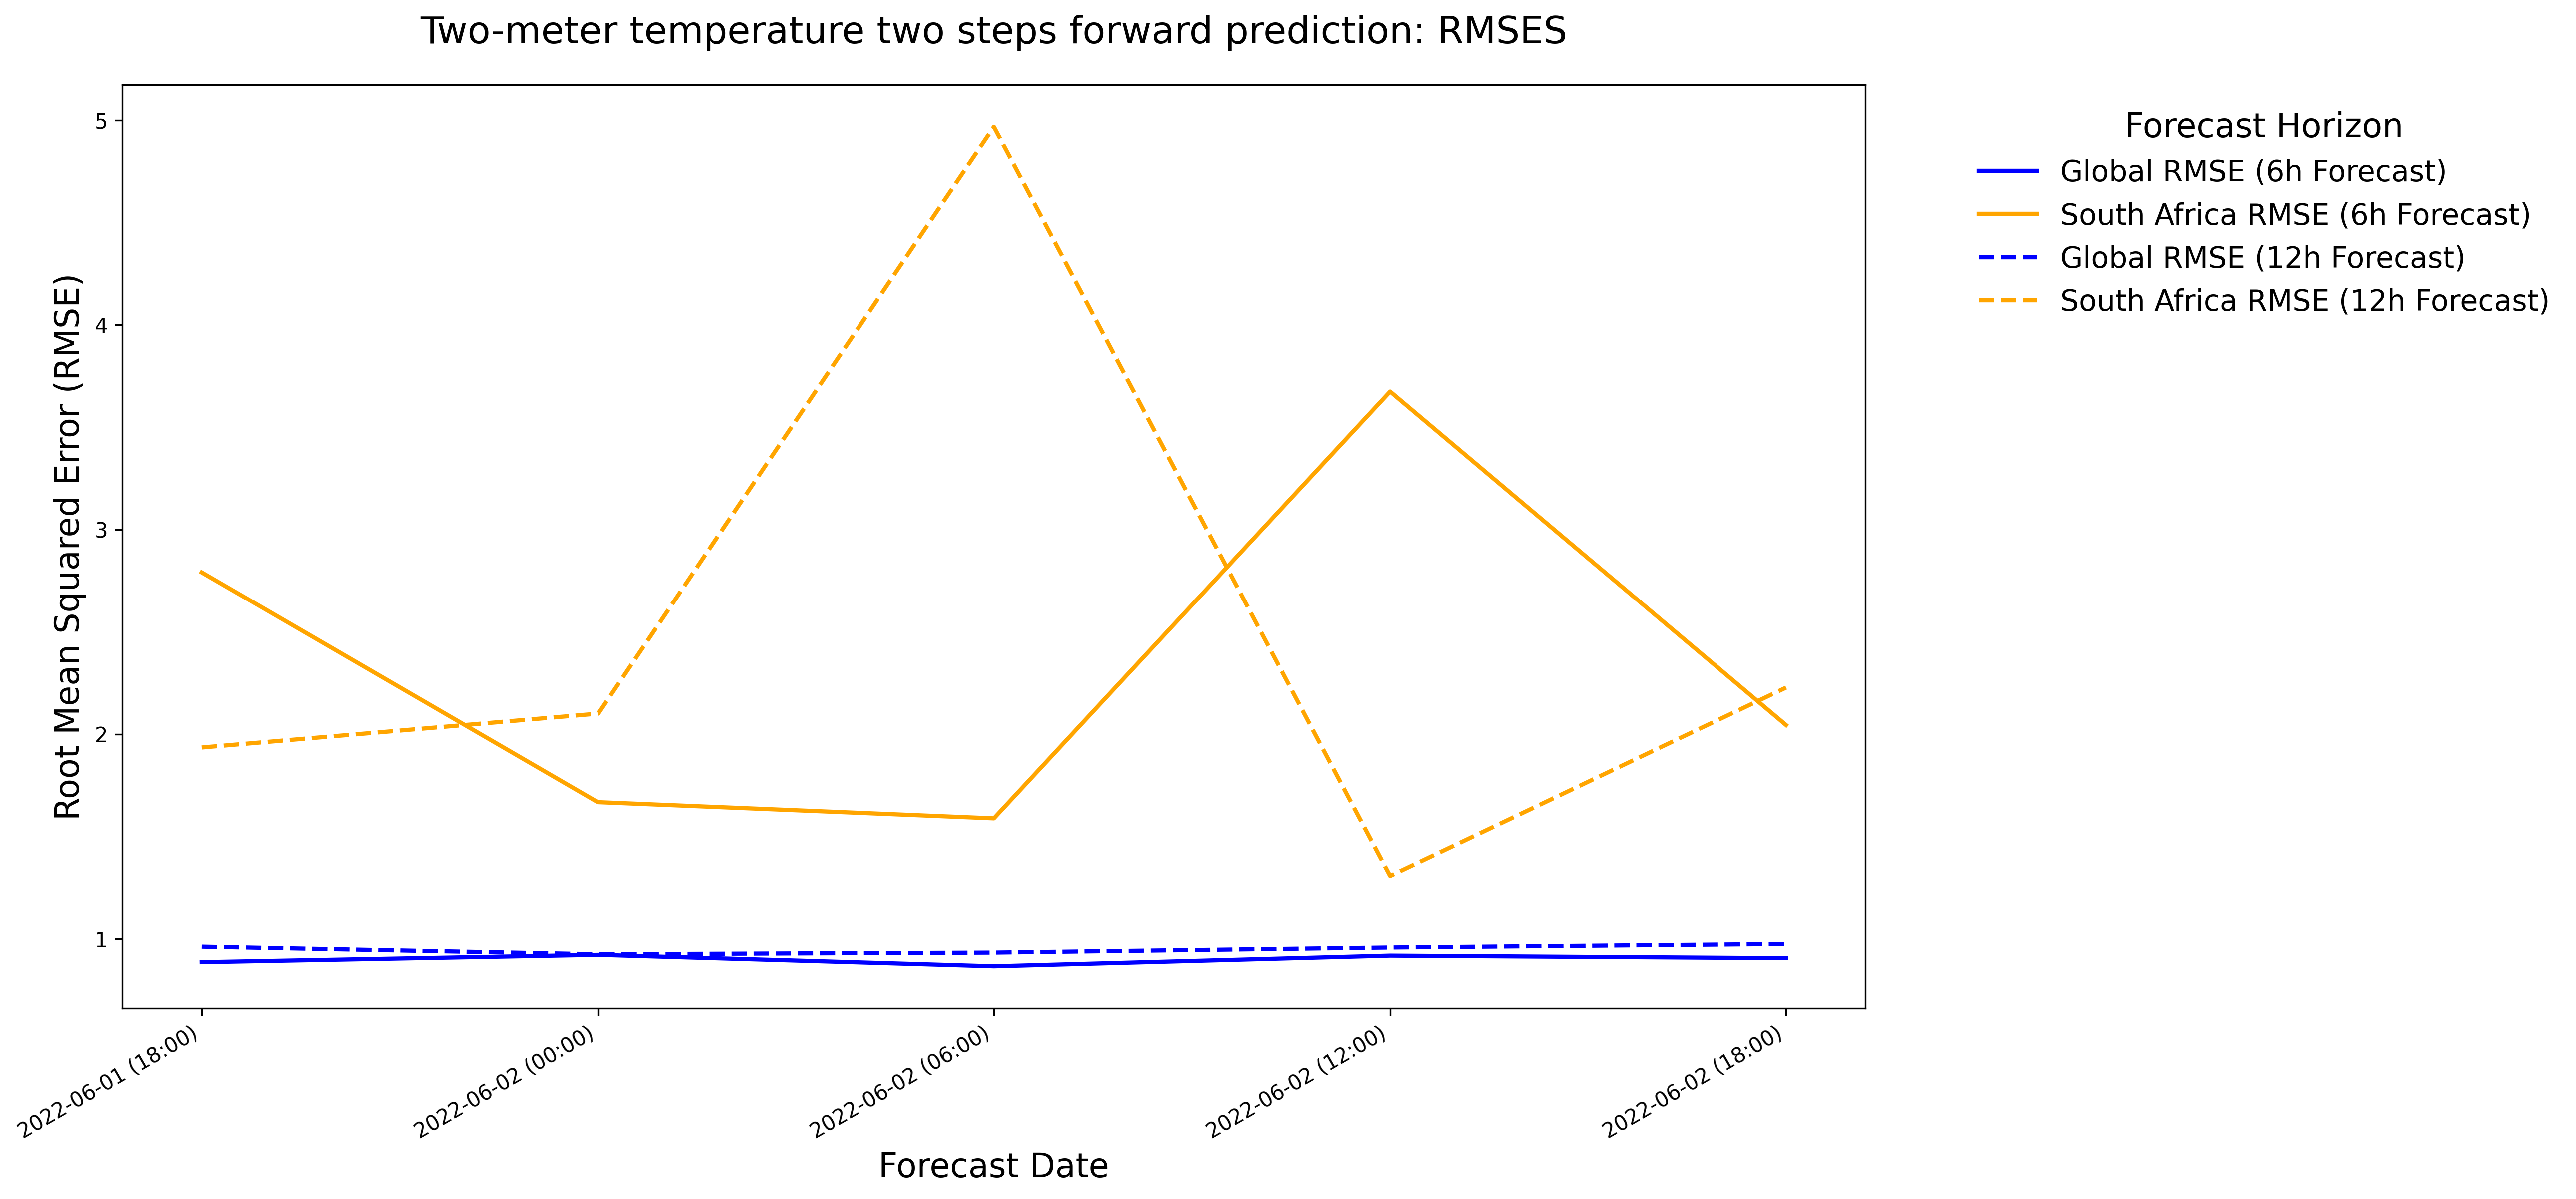

In [57]:
plot_rmses("2t",rmses_world_2t, rmses_SA_2t, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_2t, title="Two-meter temperature two steps forward prediction: RMSES")

## Ten-meter eastward wind speed in m/s :U10

In [ ]:
rmses_world_u10 = []
dates_world_u10 = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch,target_batch, "10u", var_type="surface")
    rmses_world_u10.append(rmse)
    dates_world_u10.append(date)

In [ ]:
rmses_SA_u10 = []
dates_SA_u10 = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "10u", var_type="surface")
    rmses_SA_u10.append(rmse)
    dates_SA_u10.append(date)

In [ ]:
plot_rmses("u10",rmses_world_u10, rmses_SA_u10, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_u10, title="Ten-meter eastward wind speed two steps forward prediction: RMSES")

## Ten-meter southward wind speed in m/s: V10

In [ ]:
rmses_world_v10 = []
dates_world_v10 = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "10v", var_type="surface")
    rmses_world_v10.append(rmse)
    dates_world_v10.append(date)

In [ ]:
rmses_SA_v10 = []
dates_SA_v10 = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "10v", var_type="surface")
    rmses_SA_v10.append(rmse)
    dates_SA_v10.append(date)

In [ ]:
plot_rmses("v10",rmses_world_v10, rmses_SA_v10, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_v10, title="Ten-meter southward wind speed two steps forward prediction: RMSES")

## Mean sea-level pressure in Pa :msl

In [ ]:
rmses_world_msl = []
dates_world_msl = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "msl", var_type="surface")
    rmses_world_msl.append(rmse)
    dates_world_msl.append(date)

In [ ]:
rmses_SA_msl = []
dates_SA_msl = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "msl", var_type="surface")
    rmses_SA_msl.append(rmse)
    dates_SA_msl.append(date)

In [ ]:
plot_rmses("msl",rmses_world_msl, rmses_SA_msl, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_msl, title="Mean sea-level pressure two steps forward prediction: RMSES")

# Atmosphere

## Temperature in K : t

### 50 hPa

In [ ]:
rmses_world_t = []
dates_world_t = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "t", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_t.append(rmse)
    dates_world_t.append(date)

In [ ]:
rmses_SA_t = []
dates_SA_t = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "t", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_t.append(rmse)
    dates_SA_t.append(date)

In [ ]:
plot_rmses("t",rmses_world_t, rmses_SA_t, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_t, title="Temperature in K  two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [ ]:
rmses_world_t_400hpa = []
dates_world_t_400hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "t", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_t_400hpa.append(rmse)
    dates_world_t_400hpa.append(date)

In [ ]:
rmses_SA_t_400hpa = []
dates_SA_t_400hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "t", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_t_400hpa.append(rmse)
    dates_SA_t_400hpa.append(date)

In [ ]:
plot_rmses("t",rmses_world_t_400hpa, rmses_SA_t_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_t_400hpa, title="Temperature in K  two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [ ]:
rmses_world_t_1000hpa = []
dates_world_t_1000hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "t", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_t_1000hpa.append(rmse)
    dates_world_t_1000hpa.append(date)

In [ ]:
rmses_SA_t_1000hpa = []
dates_SA_t_1000hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "t", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_t_1000hpa.append(rmse)
    dates_SA_t_1000hpa.append(date)

In [ ]:
plot_rmses("t",rmses_world_t_1000hpa, rmses_SA_t_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_t_1000hpa, title="Temperature in K  two steps forward prediction: RMSES",
            atmos_level="1000hPa")

## Eastward wind speed in m/s u

### 50 hPa

In [ ]:
rmses_world_u = []
dates_world_u = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "u", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_u.append(rmse)
    dates_world_u.append(date)

In [ ]:
rmses_SA_u = []
dates_SA_u = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "u", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_u.append(rmse)
    dates_SA_u.append(date)

In [ ]:
plot_rmses("u",rmses_world_u, rmses_SA_u, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_u, title="Eastward wind speed two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [ ]:
rmses_world_u_400hpa = []
dates_world_u_400hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "u", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_u_400hpa.append(rmse)
    dates_world_u_400hpa.append(date)

In [ ]:
rmses_SA_u_400hpa = []
dates_SA_u_400hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "u", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_u_400hpa.append(rmse)
    dates_SA_u_400hpa.append(date)

In [ ]:
plot_rmses("u",rmses_world_u_400hpa, rmses_SA_u_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_u_400hpa, title="Eastward wind speed  two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [ ]:
rmses_world_u_1000hpa = []
dates_world_u_1000hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, "u", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_u_1000hpa.append(rmse)
    dates_world_u_1000hpa.append(date)

In [ ]:
rmses_SA_u_1000hpa = []
dates_SA_u_1000hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "u", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_u_1000hpa.append(rmse)
    dates_SA_u_1000hpa.append(date)

In [ ]:
plot_rmses("u",rmses_world_u_1000hpa, rmses_SA_u_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_u_1000hpa, title="Eastward wind speed  two steps forward prediction: RMSES",
            atmos_level="1000hPa")

### Southward wind speed in m/s :v

### 50 hPa

In [ ]:
rmses_world_v = []
dates_world_v = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "v", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_v.append(rmse)
    dates_world_v.append(date)

In [ ]:
rmses_SA_v = []
dates_SA_v = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "v", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_v.append(rmse)
    dates_SA_v.append(date)

In [ ]:
plot_rmses("v",rmses_world_v, rmses_SA_v, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_v, title="Southward wind speed two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [ ]:
rmses_world_v_400hpa = []
dates_world_v_400hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "v", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_v_400hpa.append(rmse)
    dates_world_v_400hpa.append(date)

In [ ]:
rmses_SA_v_400hpa = []
dates_SA_v_400hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "v", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_v_400hpa.append(rmse)
    dates_SA_v_400hpa.append(date)

In [ ]:
plot_rmses("v",rmses_world_v_400hpa, rmses_SA_v_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_v_400hpa, title="Southward wind speed  two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [ ]:
rmses_world_v_1000hpa = []
dates_world_v_1000hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "v", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_v_1000hpa.append(rmse)
    dates_world_v_1000hpa.append(date)

In [ ]:
rmses_SA_v_1000hpa = []
dates_SA_v_1000hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "v", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_v_1000hpa.append(rmse)
    dates_SA_v_1000hpa.append(date)

In [ ]:
plot_rmses("v",rmses_world_v_1000hpa, rmses_SA_v_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_v_1000hpa, title="Southward wind speed  two steps forward prediction: RMSES",
            atmos_level="1000hPa")

### Specific humidity in kg / kg: q

### 50 hPa

In [ ]:
rmses_world_q = []
dates_world_q = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "q", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_q.append(rmse)
    dates_world_q.append(date)

In [ ]:
rmses_SA_q = []
dates_SA_q = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "q", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_q.append(rmse)
    dates_SA_q.append(date)

In [ ]:
plot_rmses("q",rmses_world_q, rmses_SA_q, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_q, title="Specific humidity two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [ ]:
rmses_world_q_400hpa = []
dates_world_q_400hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "q", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_q_400hpa.append(rmse)
    dates_world_q_400hpa.append(date)

In [ ]:
rmses_SA_q_400hpa = []
dates_SA_q_400hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "q", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_q_400hpa.append(rmse)
    dates_SA_q_400hpa.append(date)

In [ ]:
plot_rmses("q",rmses_world_q_400hpa, rmses_SA_q_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_q_400hpa, title="Specific humidity  two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [ ]:
rmses_world_q_1000hpa = []
dates_world_q_1000hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "q", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_q_1000hpa.append(rmse)
    dates_world_q_1000hpa.append(date)

In [ ]:
rmses_SA_q_1000hpa = []
dates_SA_q_1000hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "q", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_q_1000hpa.append(rmse)
    dates_SA_q_1000hpa.append(date)

In [ ]:
plot_rmses("q",rmses_world_q_1000hpa, rmses_SA_q_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_q_1000hpa, title="Specific humidity  two steps forward prediction: RMSES",
            atmos_level="1000hPa")

### Geopotential in m^2 / s^2 : z

### 50 hPa

In [ ]:
rmses_world_z = []
dates_world_z = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "z", var_type="atmosphere", atmos_level_idx=0)
    rmses_world_z.append(rmse)
    dates_world_z.append(date)

In [ ]:
rmses_SA_z = []
dates_SA_z = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "z", var_type="atmosphere", atmos_level_idx=0)
    rmses_SA_z.append(rmse)
    dates_SA_z.append(date)

In [ ]:
plot_rmses("z",rmses_world_z, rmses_SA_z, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_z, title="Geopotential two steps forward prediction: RMSES",
            atmos_level="50hPa")

### 100 hPa

### 150 hPa

### 200 hPa

### 250 hPa

### 300 hPa

### 400 hPa

In [ ]:
rmses_world_z_400hpa = []
dates_world_z_400hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "z", var_type="atmosphere", atmos_level_idx=6)
    rmses_world_z_400hpa.append(rmse)
    dates_world_z_400hpa.append(date)

In [ ]:
rmses_SA_z_400hpa = []
dates_SA_z_400hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "z", var_type="atmosphere", atmos_level_idx=6)
    rmses_SA_z_400hpa.append(rmse)
    dates_SA_z_400hpa.append(date)

In [ ]:
plot_rmses("z",rmses_world_z_400hpa, rmses_SA_z_400hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_world_z_400hpa, title="Geopotential two steps forward prediction: RMSES",
            atmos_level="400hPa")

### 500 hPa

### 600hPa

### 700 hPa

### 850 hPa

### 925 hPa

### 1000 hPa

In [ ]:
rmses_world_z_1000hpa = []
dates_world_z_1000hpa = []
for batch, target_batch in zip(world_batches, target_world_batches):
    rmse, date = rmse_fn(model, batch, target_batch, "z", var_type="atmosphere", atmos_level_idx=12)
    rmses_world_z_1000hpa.append(rmse)
    dates_world_z_1000hpa.append(date)

In [ ]:
rmses_SA_z_1000hpa = []
dates_SA_z_1000hpa = []
for batch, target_batch in zip(SA_batches, target_SA_batches):
    rmse, date = rmse_fn_sa(model, batch, target_batch, "z", var_type="atmosphere", atmos_level_idx=12)
    rmses_SA_z_1000hpa.append(rmse)
    dates_SA_z_1000hpa.append(date)

In [ ]:
plot_rmses("z",rmses_world_z_1000hpa, rmses_SA_z_1000hpa, 
            figsize=(15, 8), fontsize=18,
            date_ranges=dates_SA_z_1000hpa, title="Geopotential  two steps forward prediction: RMSES",
            atmos_level="1000hPa")